In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
import keras
from keras.models import Sequential,Model
from keras.layers import Input,Dense, Dropout, Flatten, Activation, Input, Average
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint

import numpy as np
import cv2, glob
import numpy as np
import os
import pandas as pd

Using TensorFlow backend.


In [0]:
import pandas as pd
sample_submission = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")

In [0]:
#COLOR CLAHE FUNC
def enhance(image_path, clip_limit=3):
    image = cv2.imread(image_path, 1)
    # convert image to LAB color model
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    return final_image

In [0]:
# read data
IMG_SIZE = 512


train_data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
print('{} samples'.format(len(train_data)))

test_data = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('{} tests'.format(len(test_data)))

train_ids = train_data['id_code'].values
train_labels = train_data['diagnosis'].values

test_ids = test_data['id_code'].values

3662 samples
1928 tests


In [0]:
TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images'
TEST_PATH = '../input/aptos2019-blindness-detection/test_images'

In [0]:
# Import support libraries
import cv2
import json
import math
import os
from PIL import Image
from zipfile import ZipFile

# Import libraries for scientific computing and plotting 
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow, Keras, Sklearn
import tensorflow as tf
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print out some versions
print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print ()
# Print out list of input files
print(os.listdir("../input/aptos2019-blindness-detection"))

%matplotlib inline

2.0.0
1.16.4
0.25.2

['test_images', 'test.csv', 'train_images', 'train.csv', 'sample_submission.csv']


In [0]:
## Function to pre-process the images
def preprocess_image(image_path, desired_size=224):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (desired_size,desired_size))
    im = cv2.addWeighted(im,4,cv2.GaussianBlur(im, (0,0), desired_size/30) ,-4 ,128)
    return im

In [0]:
N = train_data.shape[0]
x_train = np.empty((N, 224,224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_data['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 3662/3662 [05:32<00:00, 11.00it/s]


In [0]:
y_train = pd.get_dummies(train_data['diagnosis']).values
y_train_single = train_data['diagnosis']
train_label = []
for x_1 in range(train_data.shape[0]):
    data = train_data['diagnosis'][x_1]
    train_label.append(data)

train_label = np.array(train_label)
print(x_train.shape)
print(y_train.shape)

(3662, 224, 224, 3)
(3662, 5)


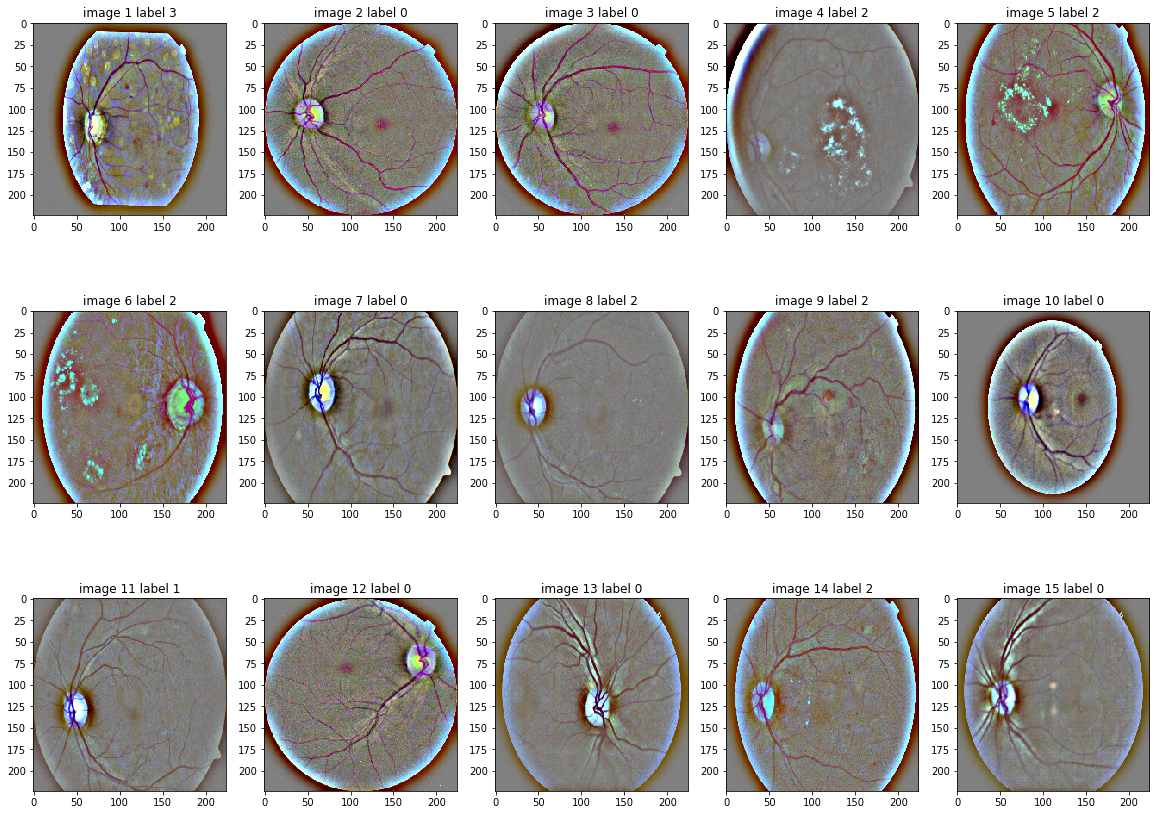

viridis


In [0]:
# randomly show 15 images

plt.figure(figsize=(20, 15))
idx = np.random.randint(0, len(x_train), size=15)

for i in range(15):
    plt.subplot(3, 5, i+1)
    im = x_train[idx[i]][..., [2, 1, 0]] # tranverse RGB to 
    im = plt.imshow(im)
    plt.title('image %s label %s' % (i+1, np.argmax(y_train[idx[i]])))
plt.show()
print(im.get_cmap().name)

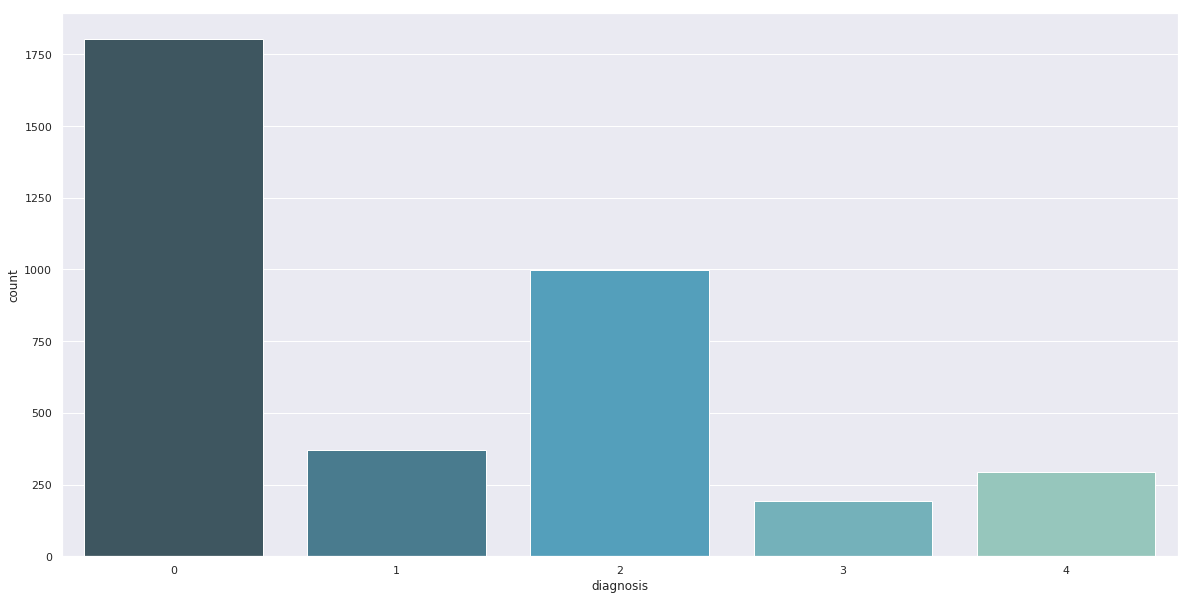

In [0]:
# show label distrubtion
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.set(style='darkgrid')
ax= sns.countplot(x='diagnosis', data=train_data, palette="GnBu_d") # accept pd.DataFrame
plt.show()

In [0]:
# customized metric.accuracy
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t) # tensor 1 / 0
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score) # no change
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', dilation_rate=(2,2), padding='same', name='dil1_conv1')(model.layers[14].output)
    x = Conv2D(512, (3, 3), activation='relu', dilation_rate=(2,2), padding='same', name='dil1_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', dilation_rate=(2,2), padding='same', name='dil1_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='dil1_pool')(x)

    concat = concatenate([model.output, x], axis=-1)
 
    out = GlobalAveragePooling2D()(concat)
    out = Dense(num_classes, activation='softmax')(out)

    model=Model(model.input,out)
    
    w_conv1, b_conv1 = model.get_layer('block5_conv1').get_weights()
    w_conv2, b_conv2 = model.get_layer('block5_conv2').get_weights()
    w_conv3, b_conv3 = model.get_layer('block5_conv3').get_weights()
    
    model.get_layer('dil1_conv1').set_weights([w_conv1, b_conv1])
    model.get_layer('dil1_conv2').set_weights([w_conv2, b_conv2])
    model.get_layer('dil1_conv3').set_weights([w_conv3, b_conv3])

    for layer in model.layers[:15]:
        layer.trainable = False


    print(model.summary())
    
    
    
    return model

In [0]:
model = vgg16_model(5)
sgd = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
from sklearn.utils import class_weight

weight = class_weight.compute_class_weight('balanced', np.unique(train_label), train_label)
cw = dict(enumerate(weight))
print(cw)


{0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [0]:
# learning rate schedule
import math
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
 

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(patience=5, verbose=1)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
model_checkpoint = ModelCheckpoint('model-vgg-generate_aptos.h5', monitor='val_acc', save_best_only='True')
checkpoint_list = [ earlystopping, model_checkpoint]

In [0]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
gen_train = ImageDataGenerator(
        rotation_range = 25,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
gen_train.fit(x_train)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', Y_train.shape)
print('The shape of X_test is:', X_test.shape)
print('The shape of y_test is:', Y_test.shape)

The shape of X_train is: (2929, 224, 224, 3)
The shape of y_train is: (2929, 5)
The shape of X_test is: (733, 224, 224, 3)
The shape of y_test is: (733, 5)


In [0]:
batch_size = 32
epochs = 30
history=model.fit_generator(gen_train.flow(x=X_train, y=Y_train, batch_size=batch_size, shuffle=True),
                       steps_per_epoch = (x_train.shape[0]//(batch_size)),
                        epochs = epochs,
                        validation_data=(X_test, Y_test),
                        class_weight=cw,
                         callbacks = checkpoint_list,verbose=1)

Epoch 1/30
114/114 [==============================] - 45s 392ms/step - loss: 0.6220 - mae: 0.1079 - accuracy: 0.8159 - val_loss: 0.7443 - val_mae: 0.1359 - val_accuracy: 0.6917
Epoch 2/30
114/114 [==============================] - 43s 380ms/step - loss: 0.6067 - mae: 0.1065 - accuracy: 0.8184 - val_loss: 0.5828 - val_mae: 0.1089 - val_accuracy: 0.7872
Epoch 3/30
114/114 [==============================] - 44s 382ms/step - loss: 0.6019 - mae: 0.1042 - accuracy: 0.8222 - val_loss: 0.7703 - val_mae: 0.1328 - val_accuracy: 0.7012
Epoch 4/30
114/114 [==============================] - 43s 380ms/step - loss: 0.6222 - mae: 0.1069 - accuracy: 0.8183 - val_loss: 0.7700 - val_mae: 0.1334 - val_accuracy: 0.7135
Epoch 5/30
114/114 [==============================] - 44s 382ms/step - loss: 0.5623 - mae: 0.1010 - accuracy: 0.8249 - val_loss: 0.6422 - val_mae: 0.1142 - val_accuracy: 0.7613
Epoch 6/30
114/114 [==============================] - 43s 380ms/step - loss: 0.5818 - mae: 0.1014 - accuracy: 0.827

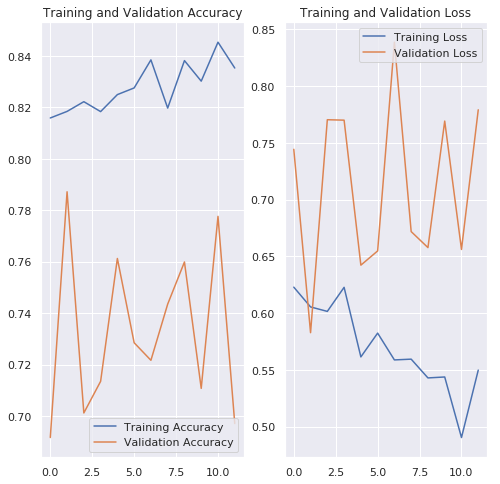

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [0]:
model.save('/kaggle/working_vgg.h5')

In [0]:
import pickle
Pkl_Filename = '/kaggle/working/CNN.pkl'
with open(Pkl_Filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [0]:
import pickle
Pkl_Filename = '/kaggle/working/cgg.pkl'
with open(Pkl_Filename, 'wb') as file_pi:
        pickle.dump(model, file_pi)

In [0]:
history= model.fit(x=x_train, y=y_train, 
           epochs = 50, batch_size = 32, 
           shuffle = True, verbose = 1, 
           validation_split=0.10,
           class_weight = cw,
           callbacks=checkpoint_list)

Train on 3295 samples, validate on 367 samples
Epoch 1/50
3295/3295 [==============================] - 13s 4ms/step - loss: 0.2010 - mae: 0.0493 - accuracy: 0.9514 - val_loss: 1.0993 - val_mae: 0.1077 - val_accuracy: 0.8038
Epoch 2/50
3295/3295 [==============================] - 13s 4ms/step - loss: 0.1866 - mae: 0.0460 - accuracy: 0.9533 - val_loss: 1.1723 - val_mae: 0.0910 - val_accuracy: 0.8120
Epoch 3/50
3295/3295 [==============================] - 13s 4ms/step - loss: 0.1646 - mae: 0.0403 - accuracy: 0.9590 - val_loss: 1.2670 - val_mae: 0.0883 - val_accuracy: 0.8120
Epoch 4/50
3295/3295 [==============================] - 13s 4ms/step - loss: 0.1641 - mae: 0.0390 - accuracy: 0.9645 - val_loss: 1.3227 - val_mae: 0.0836 - val_accuracy: 0.8202
Epoch 5/50
3295/3295 [==============================] - 13s 4ms/step - loss: 0.1445 - mae: 0.0351 - accuracy: 0.9690 - val_loss: 1.1635 - val_mae: 0.0910 - val_accuracy: 0.7984
Epoch 6/50
3295/3295 [==============================] - 13s 4ms/step

In [0]:
import os
os.chdir(r'/kaggle/working')

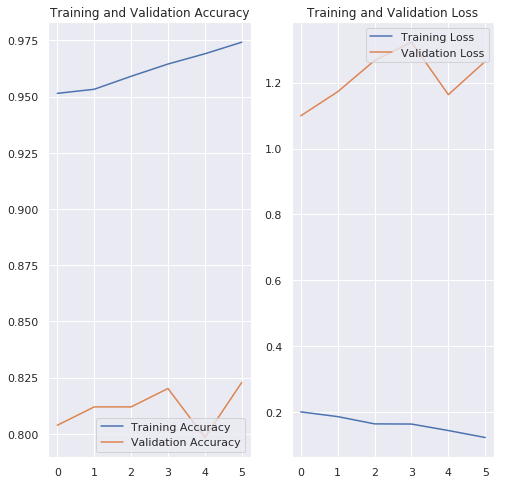

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [0]:
model.save('/kaggle/working/vgg.h5')

In [0]:
import pickle
Pkl_Filename = '/kaggle/working/vgg.pkl'
with open(Pkl_Filename, 'wb') as file_pi:
        pickle.dump(model, file_pi)